In [2]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
#restart the runtime then

     |████████████████████████████████| 25.0MB 1.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 155kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
#using Google Colab, image located in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import glob, random, imageio
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pandas as pd
import math
import pickle
# from sklearn.feature_extraction.text import TfidfTransformer
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
n_categories = 20
n_images = math.inf #math.inf #equals to max
k = 500

In [ ]:
directory_dataset = '/content/drive/My Drive/A4/101_ObjectCategories/'
categories = []

split_by = 2
img_dim = 3

train_tuple = []
test_tuple = []

for name in glob.glob(directory_dataset + '*'): 
    categories.append(name.replace(directory_dataset,''))

print("# of categories", len(categories))

# selected_categories = random.sample(categories, n_categories)
selected_categories = categories[:n_categories]
print("Actual number of categories", len(selected_categories))

for i in range(len(selected_categories)):
  img_list = glob.glob(directory_dataset + selected_categories[i] + '/*.jpg')
  random.shuffle(img_list)
  # img_list = img_list[:n_images]
  category_length = len(img_list)

  counter = 0
  for image_path in img_list[int(category_length/split_by):]:
    img = imageio.imread(image_path)
    if counter > n_images:
      break
    if len(img.shape) != img_dim:
      break
    train_tuple.append((image_path, img))
    counter += 1

  counter = 0
  for image_path in img_list[:int(category_length/split_by)]:
    img = imageio.imread(image_path)
    if counter > n_images:
      break
    if len(img.shape) != img_dim:
      break
    test_tuple.append((image_path, img))
    counter += 1

train = []
test = []

for x in train_tuple: train.append(x[1])
for x in test_tuple: test.append(x[1])

train = np.array(train, dtype=object).reshape((1,-1))
test = np.array(test, dtype=object).reshape((1,-1))

print("# of images", len(train[0])+len(test[0]))

# of categories 102
Actual number of categories 20


In [ ]:
cv2_imshow(train[0][2])

In [ ]:
print(train.shape)
print(test.shape)

#1 Codebook Generation

In [ ]:
def compute_des_list(data_set):
  des_list = []
  sift = cv.xfeatures2d.SIFT_create()
  
  for img in data_set:
    for i in range(len(img)):
      _, des = sift.detectAndCompute(img[i], None)
      des_list.append((img[i], des))
  return des_list

train_des_list = compute_des_list(train)

In [ ]:
descriptors = train_des_list[0][1]
for _, descriptor in train_des_list[1:]:
  descriptors = np.vstack((descriptors, descriptor))

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=0, verbose=0).fit(descriptors)

## Form the BoW for each image in the training set

In [ ]:
def compute_bow(des_list):
  sift = cv.xfeatures2d.SIFT_create()
  bow_list = []  
  for img in des_list:
    kp, des = sift.detectAndCompute(img[0], None)
    bow = np.zeros(k)
    nkp = np.size(kp)
    pred = kmeans.predict(img[1])

    for clust in pred:
      bow[clust] += 1/nkp # If you want percentage BOW
      # bow[clust] += 1 # If you want actual BOW

    bow_list.append(bow)
  return bow_list

train_bow = compute_bow(train_des_list)

barrel


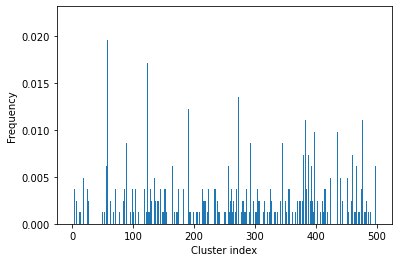

In [ ]:
def plot_histogram(bow, n):
  plt.xlabel('Cluster index')
  plt.ylabel('Frequency')
  plt.bar([x for x in range(k)], bow[n])

plot_histogram(train_bow, 0)
print(categories[0])

#2 Indexing

In [ ]:
test_des_list = compute_des_list(test)
test_bow = compute_bow(test_des_list)

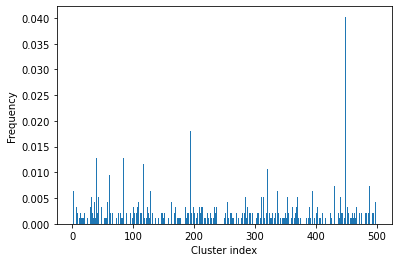

In [ ]:
plot_histogram(test_bow, 0)

## Save predictions and model

In [ ]:
rows_list = []

for i in range(len(train_tuple)):
  dict1 = {}
  dict1.update({'Path' : train_tuple[i][0], 'True_category' : train_tuple[i][0].split("/")[6], 'Dataset' : 'train', 'BOW' : train_bow[i]})
  rows_list.append(dict1)

for i in range(len(test_tuple)):
  dict1 = {}
  dict1.update({'Path' : test_tuple[i][0], 'True_category' : test_tuple[i][0].split("/")[6], 'Dataset' : 'test', 'BOW' : test_bow[i]})
  rows_list.append(dict1)

df = pd.DataFrame(rows_list, columns=['Path', 'True_category', 'Dataset', 'BOW'])
df

,Path,True_category,Dataset,BOW
0,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.0012254901960784314, 0.0012254901960784314,..."
1,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.012295081967213115, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.0, 0.0, 0.0, 0.0, 0.017241379310344827, 0.0..."
3,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.0031446540880503146, 0.0, 0.015723270440251..."
4,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.006622516556291391, 0.0033112582781456954, ..."
...,...,...,...,...
1366,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,test,"[0.0, 0.00816326530612245, 0.01224489795918367..."
1367,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,test,"[0.0, 0.0, 0.008733624454148471, 0.0, 0.004366..."
1368,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,test,"[0.0, 0.003367003367003367, 0.0, 0.00336700336..."
1369,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,test,"[0.0, 0.0, 0.01976284584980237, 0.0, 0.0118577..."


In [ ]:
# df.to_csv('/content/drive/My Drive/A4/BOW.csv', sep=',')

In [ ]:
# pickle.dump(kmeans, open('/content/drive/My Drive/A4/BOW_Kmeans_model.sav', 'wb'))

#3 Retrieving

In [ ]:
# We split the dataset again as we have to retrieve images from the training set
# and data set separately
df_train = df.loc[df['Dataset'] == "train"]
df_test = df.loc[df['Dataset'] == "test"]

def sort(lst, boo):
  return sorted(lst, key=lambda x: x[0], reverse=boo)

# Given the full dataset (df_full), a subset of the dataset (df_sub (either df_train or df_test))
# and a function (fun), we calculate the similarity between each image in the
# subset and each image in the full dataset using fun. The list of similarities
# is sorted (from high similarity to low similarity)
# and then added to the pandas dataframe. 
def compute_similarities(df_sub, df_full, fun, boo):
  all_dst_lst = []
  for _, row1 in df_sub.iterrows():
    dst_lst = []
    for _, row2 in df_full.iterrows():
      if row1["Path"] == row2["Path"]: # No need to find similarity between same image
        continue
      dst = fun(row1["BOW"], row2["BOW"])
      dst_lst.append([dst, row2["True_category"]])
    all_dst_lst.append(dst_lst)
  df_sub["distance list"] = all_dst_lst
  df_sub["distance list"] = df_sub["distance list"].apply(sort, args=(boo,),)
  return df_sub

In [ ]:
# The Bhattacharyya distance
bhattacharyya = lambda v1, v2: sum(np.sqrt(np.multiply(v1, v2)))

new_df_train = compute_similarities(df_train, df, bhattacharyya, True)
new_df_test = compute_similarities(df_test, df, bhattacharyya, True)

In [ ]:
new_df_train

,Path,True_category,Dataset,BOW,distance list
0,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.0012254901960784314, 0.0012254901960784314,...","[[0.7122933572173094, bonsai], [0.707626217123..."
1,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.012295081967213115, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.5959378431471105, cannon], [0.558385447898..."
2,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.0, 0.0, 0.0, 0.0, 0.017241379310344827, 0.0...","[[0.3571038958848025, butterfly], [0.346245683..."
3,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.0031446540880503146, 0.0, 0.015723270440251...","[[0.5940569365872083, BACKGROUND_Google], [0.5..."
4,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.006622516556291391, 0.0033112582781456954, ...","[[0.6070873419683432, bonsai], [0.606567136472..."
...,...,...,...,...,...
716,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,train,"[0.0034423407917383822, 0.0, 0.003442340791738...","[[0.7234811656988359, BACKGROUND_Google], [0.7..."
717,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,train,"[0.0, 0.005263157894736842, 0.0017543859649122...","[[0.7447804769702144, BACKGROUND_Google], [0.7..."
718,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,train,"[0.0, 0.0, 0.004576659038901602, 0.0, 0.0, 0.0...","[[0.6831692094433273, buddha], [0.672855117322..."
719,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,train,"[0.0, 0.0027675276752767526, 0.006457564575645...","[[0.8187743355820721, BACKGROUND_Google], [0.8..."


In [ ]:
print(new_df_train.iloc[42])
new_df_train["distance list"].iloc[42]

## Compute the mean reciprocal rank and how often the correct category is in top-3

In [ ]:
# The mean reciprocal rank
def reciprocal_rank(df):
  true_category = df["True_category"]
  dist_lst = np.array(df["distance list"])[:,1]
  rank = np.argwhere(dist_lst == true_category)[0][0]
  return 1/(rank+1)

new_df_train["reciprocal_rank"] = new_df_train.apply(reciprocal_rank, axis = 1)
new_df_test["reciprocal_rank"] = new_df_test.apply(reciprocal_rank, axis = 1)

In [ ]:
# How often (in per cent) the correct category is in top-3
def is_top3(df):
  true_category = df["True_category"]
  top3 = np.array(df["distance list"])[:3]
  ret_val = 1 if true_category in top3[:,1] else 0
  return ret_val

new_df_train["is_top3"] = new_df_train.apply(is_top3, axis = 1)
new_df_test["is_top3"] = new_df_test.apply(is_top3, axis = 1)

In [ ]:
new_df_train

,Path,True_category,Dataset,BOW,distance list,reciprocal_rank,is_top3
0,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.0012254901960784314, 0.0012254901960784314,...","[[0.7122933572173094, bonsai], [0.707626217123...",0.333333,1
1,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.012295081967213115, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.5959378431471105, cannon], [0.558385447898...",0.041667,0
2,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.0, 0.0, 0.0, 0.0, 0.017241379310344827, 0.0...","[[0.3571038958848025, butterfly], [0.346245683...",0.022222,0
3,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.0031446540880503146, 0.0, 0.015723270440251...","[[0.5940569365872083, BACKGROUND_Google], [0.5...",0.034483,0
4,/content/drive/My Drive/A4/101_ObjectCategorie...,barrel,train,"[0.006622516556291391, 0.0033112582781456954, ...","[[0.6070873419683432, bonsai], [0.606567136472...",0.047619,0
...,...,...,...,...,...,...,...
716,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,train,"[0.0034423407917383822, 0.0, 0.003442340791738...","[[0.7234811656988359, BACKGROUND_Google], [0.7...",0.090909,0
717,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,train,"[0.0, 0.005263157894736842, 0.0017543859649122...","[[0.7447804769702144, BACKGROUND_Google], [0.7...",0.200000,0
718,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,train,"[0.0, 0.0, 0.004576659038901602, 0.0, 0.0, 0.0...","[[0.6831692094433273, buddha], [0.672855117322...",1.000000,1
719,/content/drive/My Drive/A4/101_ObjectCategorie...,buddha,train,"[0.0, 0.0027675276752767526, 0.006457564575645...","[[0.8187743355820721, BACKGROUND_Google], [0.8...",0.142857,0


In [ ]:
print("Mean reciprocal rank for training data using bhattacharyya distance:", np.average(new_df_train["reciprocal_rank"]))
print("Mean reciprocal rank for test data using bhattacharyya distance:", np.average(new_df_test["reciprocal_rank"]))

print("How often the correct category is in top-3 for training data using bhattacharyya distance:", np.average(new_df_train["is_top3"]),"%")
print("How often the correct category is in top-3 for test data using bhattacharyya distance:", np.average(new_df_test["is_top3"]),"%")

Mean reciprocal rank for training data using bhattacharyya distance: 0.5049941072069193
Mean reciprocal rank for test data using bhattacharyya distance: 0.441747519111109
How often the correct category is in top-3 for training data using bhattacharyya distance: 0.5852981969486823 %
How often the correct category is in top-3 for test data using bhattacharyya distance: 0.5107692307692308 %


In [ ]:
kullback = lambda v1, v2: sum(np.multiply(v1, np.log(v1) - np.log(v2)))

new_df_train = compute_similarities(df_train, df, kullback, False)
new_df_test = compute_similarities(df_test, df, kullback, False)

new_df_train["kullback_rank"] = new_df_train.apply(reciprocal_rank, axis = 1)
new_df_test["kullback_rank"] = new_df_test.apply(reciprocal_rank, axis = 1)

new_df_train["kullback_is_top3"] = new_df_train.apply(is_top3, axis = 1)
new_df_test["kullback_is_top3"] = new_df_test.apply(is_top3, axis = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [ ]:
print("Mean reciprocal rank for training data using kullback distance:", np.average(new_df_train["kullback_rank"]))
print("Mean reciprocal rank for test data using kullback distance:", np.average(new_df_test["kullback_rank"]))

print("How often the correct category is in top-3 for training data using bhattacharyya distance:", np.average(new_df_train["kullback_is_top3"]))
print("How often the correct category is in top-3 for test data using bhattacharyya distance:", np.average(new_df_test["kullback_is_top3"]))

Mean reciprocal rank for training data using kullback distance: 0.02625414086660568
Mean reciprocal rank for test data using kullback distance: 0.040548273463758014
How often the correct category is in top-3 for training data using bhattacharyya distance: 0.012482662968099861
How often the correct category is in top-3 for test data using bhattacharyya distance: 0.026153846153846153


In [ ]:
new_df_train_1 = compute_similarities(df_train, df, kullback, False)
new_df_test_1 = compute_similarities(df_test, df, kullback, False)

new_df_train_2 = compute_similarities(df, df_train, kullback, False)
new_df_test_2 = compute_similarities(df, df_test, kullback, False)

new_df_train = ((new_df_train_1 + new_df_train_2) * (1/2))
new_df_test = ((new_df_test_1 + new_df_test_2) * (1/2))

new_df_train["kullback_rank"] = new_df_train.apply(reciprocal_rank, axis = 1)
new_df_test["kullback_rank"] = new_df_test.apply(reciprocal_rank, axis = 1)

new_df_train["kullback_is_top3"] = new_df_train.apply(is_top3, axis = 1)
new_df_test["kullback_is_top3"] = new_df_test.apply(is_top3, axis = 1)